<a href="https://colab.research.google.com/github/hvr2026/Data-Science-Methodologies/blob/main/SEMMA/SEMMA_Credit_Card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score


In [2]:
# Load the dataset
data = pd.read_csv('/content/creditcard.csv')

In [3]:
### 1. SAMPLE ###

# Print dataset information
print("Dataset Shape:", data.shape)
print("Class Distribution:\n", data['Class'].value_counts())


Dataset Shape: (284807, 31)
Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
# Separate fraud and non-fraud classes
fraud = data[data['Class'] == 1]
non_fraud = data[data['Class'] == 0]

# If needed, downsample non-fraud class for balance (comment out if using the full dataset)
non_fraud_sample = non_fraud.sample(len(fraud) * 5, random_state=42)
data_sampled = pd.concat([fraud, non_fraud_sample]).sample(frac=1, random_state=42).reset_index(drop=True)


In [5]:
### 2. EXPLORE ###

# Check for missing values
missing_values = data_sampled.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])


Missing Values:
 Series([], dtype: int64)


In [6]:
# Descriptive statistics
print(data_sampled.describe())

                Time           V1           V2           V3           V4  \
count    2952.000000  2952.000000  2952.000000  2952.000000  2952.000000   
mean    92532.301491    -0.804534     0.564072    -1.201008     0.745979   
std     47987.819983     3.758173     2.710198     4.117980     2.422184   
min        56.000000   -30.552380   -29.336007   -31.103685    -4.729482   
25%     51150.000000    -1.298091    -0.487195    -1.603748    -0.719883   
50%     84226.500000    -0.259909     0.219359    -0.194663     0.277998   
75%    137782.250000     1.238906     1.111429     0.802366     1.303598   
max    172619.000000     2.370007    22.057729     3.770236    12.114672   

                V5           V6           V7           V8           V9  ...  \
count  2952.000000  2952.000000  2952.000000  2952.000000  2952.000000  ...   
mean     -0.472148    -0.235164    -0.946182     0.101100    -0.420075  ...   
std       2.798330     1.549425     3.740097     2.963971     1.725863  ...   

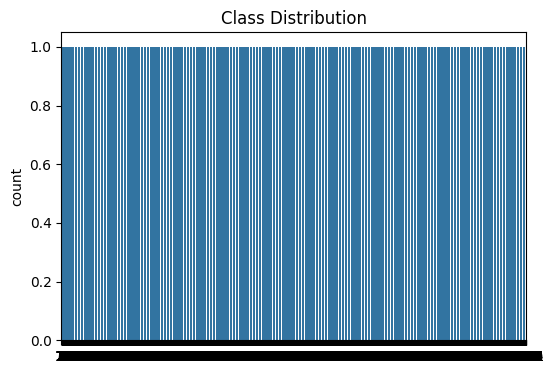

In [7]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data_sampled['Class'])
plt.title("Class Distribution")
plt.show()

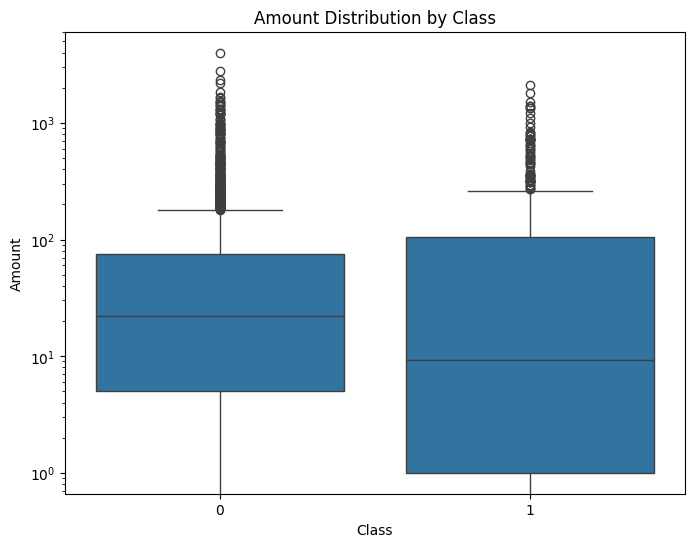

In [8]:
# Boxplot for amount distribution by class (fraud vs. non-fraud)
plt.figure(figsize=(8, 6))
sns.boxplot(x="Class", y="Amount", data=data_sampled)
plt.yscale("log")
plt.title("Amount Distribution by Class")
plt.show()

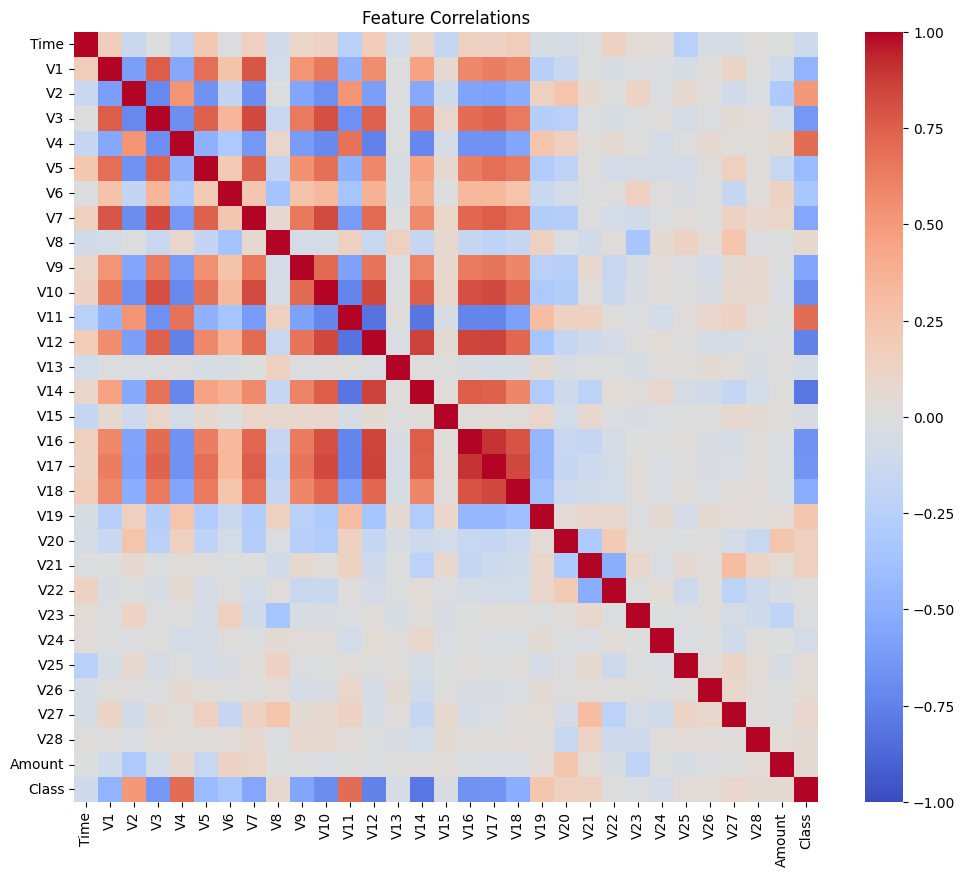

In [9]:
# Visualize feature correlation with heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data_sampled.corr(), cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlations")
plt.show()

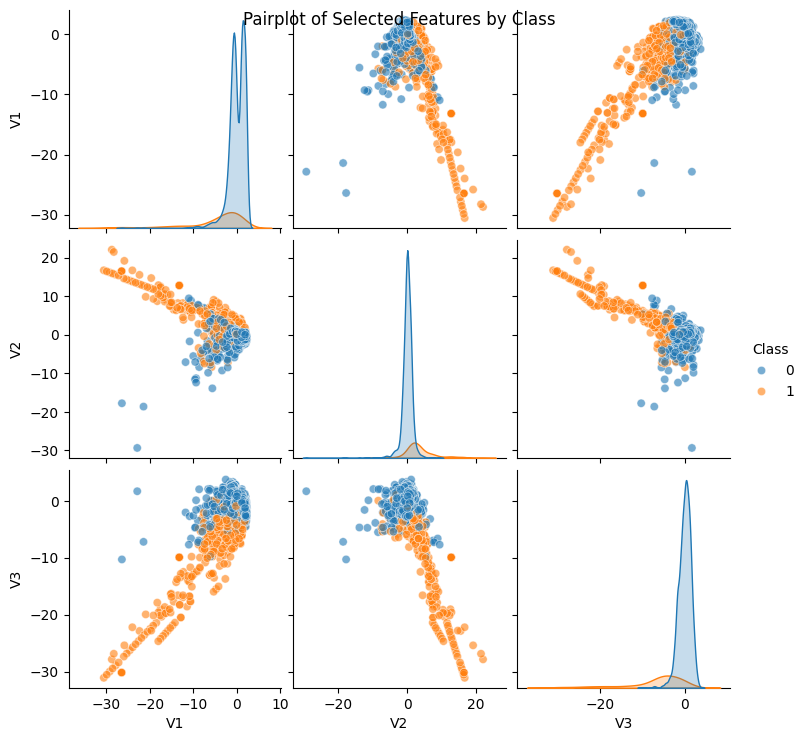

In [10]:
# Pairplot for selected features (e.g., V1, V2, V3) to observe separation between classes
sns.pairplot(data_sampled[['V1', 'V2', 'V3', 'Class']], hue="Class", plot_kws={'alpha':0.6})
plt.suptitle("Pairplot of Selected Features by Class")
plt.show()

In [11]:
### 3. MODIFY ###

# Separate features and target variable
X = data_sampled.drop('Class', axis=1)
y = data_sampled['Class']

# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
### 4. MODEL ###

# Using Stratified Shuffle Split to maintain class distribution in train-test split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Build a Random Forest Classifier with cross-validation for better accuracy
model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-Validation ROC AUC Scores:", cv_scores)
print("Average CV ROC AUC Score:", np.mean(cv_scores))

Cross-Validation ROC AUC Scores: [0.9657845  0.97474425 0.96115605 0.97634395 0.98927789]
Average CV ROC AUC Score: 0.9734613269407644


In [13]:
# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [14]:
### 5. ASSESS ###

# Make predictions and calculate probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [15]:

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [16]:
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Precision:", precision)
print("Recall:", recall)
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9808126410835214
ROC AUC Score: 0.9832042408261921
Precision: 0.9851851851851852
Recall: 0.8986486486486487
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       738
           1       0.99      0.90      0.94       148

    accuracy                           0.98       886
   macro avg       0.98      0.95      0.96       886
weighted avg       0.98      0.98      0.98       886



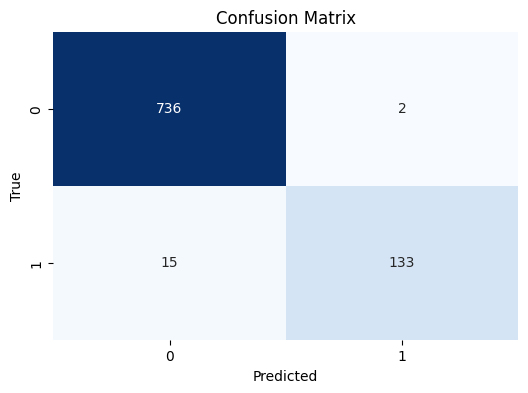

In [17]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# ROC Curve Plot
from sklearn.metrics import roc_curve

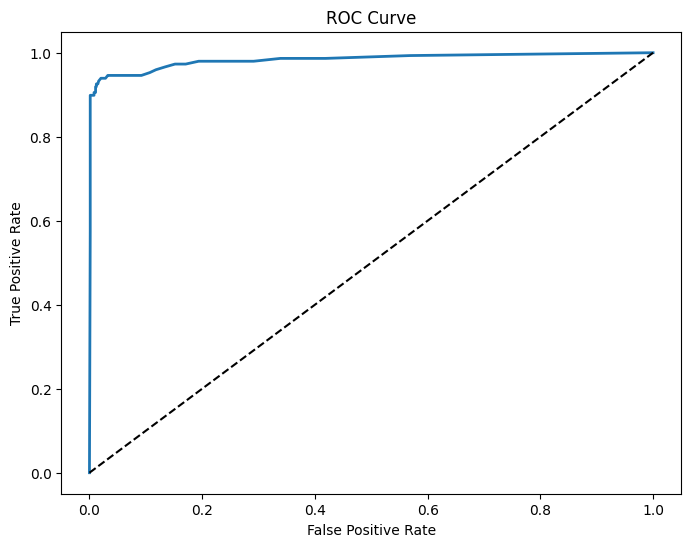

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()